In [23]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pickle

In [24]:
N = 20

def cat_factory(n, alpha=1):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)
    
    return cat_n / cat_n.norm()

def cat_dm_factory(n, alpha=1):
    return cat_factory(n, alpha=alpha).todm()

def plot_wigner(xvals, yvals, wigner_values):
    plt.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
    plt.colorbar()

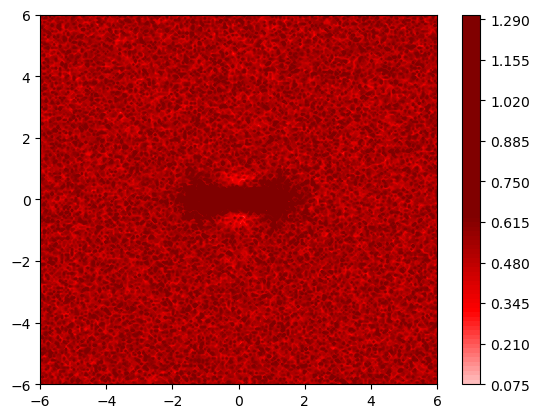

In [25]:
state = cat_factory(2)
xvec, yvec, wigner = dq.wigner(state)

a = 1.
b = 0.5
sigma = 0.1
noise = np.random.normal(0.0, scale=sigma, size=wigner.shape)

wigner_noisy = a*wigner + b*np.ones_like(wigner) + noise

plot_wigner(xvec, yvec, wigner_noisy)






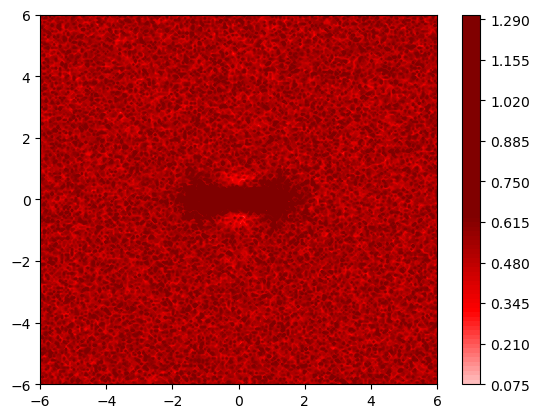

In [26]:
import numpy as np
from scipy.ndimage import gaussian_filter, uniform_filter

# assume wigner_noisy is your 2D array

# 1. build binary masks of positive and negative
pos_mask = (wigner_noisy > 0).astype(float)
neg_mask = (wigner_noisy < 0).astype(float)

# 2. choose a window size (in pixels) over which to look for clusters
win = 11   # e.g. 11×11 neighborhood

# 3. compute local counts (actually local fractions) of positives/negatives
# uniform_filter sums (here since mask is 0/1, it gives count) then we normalize by total window size
local_pos_frac = uniform_filter(pos_mask, size=win)
local_neg_frac = uniform_filter(neg_mask, size=win)

# 4. define your cluster thresholds
# for instance, if more than 50% of the window is positive (resp. negative):
thr = 0.3

cluster_mask = (local_pos_frac > thr) & (local_neg_frac > thr)

# 5. make a heavily‐smoothed version of the whole noisy Wigner
smooth_heavy = gaussian_filter(wigner_noisy, sigma=5)

# 6. combine: apply the heavy smooth only inside clusters
wigner_denoised = wigner_noisy.copy()
wigner_denoised_np=np.array(wigner_denoised)
wigner_denoised_np[cluster_mask] = smooth_heavy[cluster_mask]

# 7. plot
plot_wigner(xvec, yvec, wigner_denoised_np)

In [27]:
def compute_offset(wigner_noisy):
    # 1. compute local mean of W and local mean of W² over a small window
    win = 10                          # size of the patch in pixels
    mean1 = uniform_filter(wigner_noisy, size=win)
    mean2 = uniform_filter(wigner_noisy**2, size=win)

    # 2. estimate the local variance: Var = E[W²] – (E[W])²
    local_var = mean2 - mean1**2

    # 3. pick a threshold for “flatness” (tune this)
    var_thr = np.percentile(local_var, 5)  
    # e.g. take the bottom 5% of variances

    # 4. build a mask of flat regions
    flat_mask = local_var <= var_thr

    # 5. estimate b by averaging wigner_noisy over all flat pixels
    b_est = np.mean(wigner_noisy[flat_mask])
    return b_est


def generate_noisy_cat(sigma):
    state = cat_factory(2)
    xvec, yvec, wigner = dq.wigner(state)

    a = 1.
    b = 0.5
    sigma = sigma
    noise = np.random.normal(0.0, scale=sigma, size=wigner.shape)

    wigner_noisy = a*wigner + b*np.ones_like(wigner) + noise
    return wigner_noisy

def rescale_wigner_whole_integral(wigner_noisy_offsetted):
    integral=np.sum(wigner_noisy_offsetted)/wigner_noisy_offsetted.shape[0]**2*12**2
    wigner_noisy_corrected=wigner_noisy_offsetted/integral
    return wigner_noisy_corrected, integral

def rescale_wigner_selected_integral(wigner_noisy_offsetted, b_est):
    def cluster_mask(b_est):
        # 1. build binary masks of positive and negative
        pos_mask = (wigner_noisy_offsetted > b_est).astype(float)
        neg_mask = (wigner_noisy_offsetted < b_est).astype(float)

        # 2. choose a window size (in pixels) over which to look for clusters
        win = 11   # e.g. 11×11 neighborhood

        # 3. compute local counts (actually local fractions) of positives/negatives
        # uniform_filter sums (here since mask is 0/1, it gives count) then we normalize by total window size
        local_pos_frac = uniform_filter(pos_mask, size=win)
        local_neg_frac = uniform_filter(neg_mask, size=win)

        # 4. define your cluster thresholds
        # for instance, if more than 50% of the window is positive (resp. negative):
        thr = 0.3

        cluster_mask = (local_pos_frac > thr) & (local_neg_frac > thr)
        return cluster_mask
    relevant_mask=np.logical_not(cluster_mask(b_est))
    relevant_mask_true_values=relevant_mask.sum()
    integral=np.sum(wigner_noisy_offsetted[relevant_mask])/wigner_noisy_offsetted.shape[0]**2*12**2
    wigner_noisy_corrected=wigner_noisy_offsetted/integral
    return wigner_noisy_corrected, integral



In [49]:
b_est_off=[]
a1_est_off=[]
a2_est_off=[]


for sigma in np.logspace(np.log10(0.005), np.log10(0.5), num=100):
    wigner_noisy=generate_noisy_cat(sigma)
    b_est=compute_offset(wigner_noisy)
    wigner_noisy_offsetted=wigner_noisy-b_est
    wigner_noisy_corrected1, a1=rescale_wigner_whole_integral(wigner_noisy_offsetted)
    wigner_noisy_corrected2, a2=rescale_wigner_selected_integral(wigner_noisy_offsetted, b_est)
    #plot_wigner(xvec, yvec, wigner_noisy_corrected1)
    #plot_wigner(xvec, yvec, wigner_noisy_corrected2)
    b_est_off.append(abs(b_est-b))
    a1_est_off.append(abs(a1-a))
    a2_est_off.append(abs(a2-a))


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/r3/73vd52695015hgxl4_8nqdth0000gn/T/ipykernel_30423/3430253005.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma$')


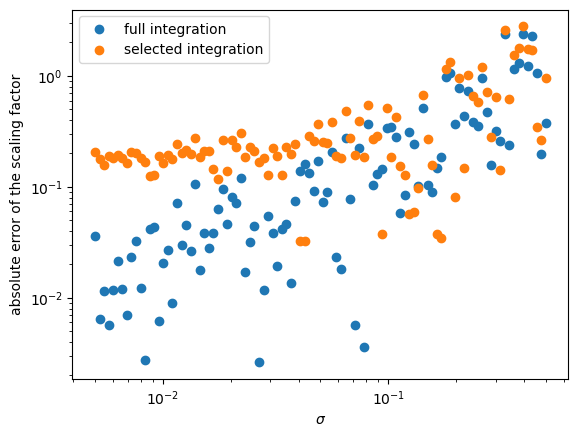

In [55]:
plt.scatter(np.logspace(np.log10(0.005), np.log10(0.5), num=100), a1_est_off, label="full integration")
plt.scatter(np.logspace(np.log10(0.005), np.log10(0.5), num=100), a2_est_off, label="selected integration")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\sigma$')
plt.ylabel('absolute error of the scaling factor')
plt.legend()

ValueError: x and y must be the same size

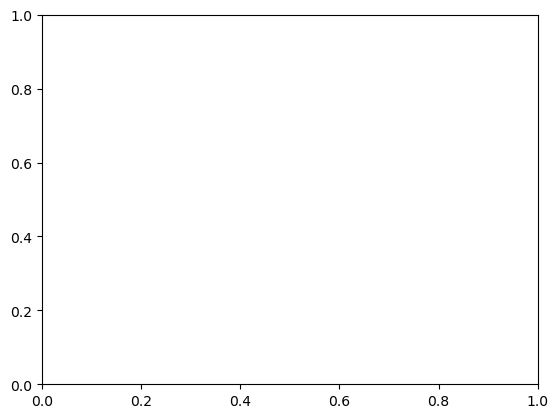

In [ ]:
plt.scatter(np.logspace(np.log10(0.005), np.log10(0.5), num=100), b_est_off)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\sigma$')
plt.ylabel('absolute error of the offset')